# Uebung Clustering und Dimensionsreduktion

## PCA

We performed some simple PCA analysis in the lecture that looked like this:

(-3.3, 3.3, -2.2, 2.2)

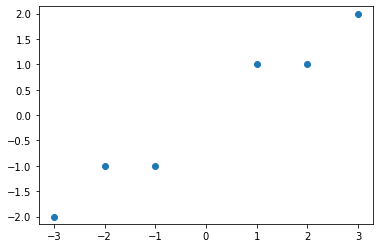

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

plt.scatter(X[:,0],X[:,1])
plt.axis('equal')

We then used the covariance matrix to extract its eigenvectors and plotted them to understand that we're actually just projecting the datapoints on the eigenvectors (which are called the principal component axes).

[0.99244289 0.00755711]
[6.30061232 0.54980396]


(-3.3, 3.3, -2.2, 2.2)

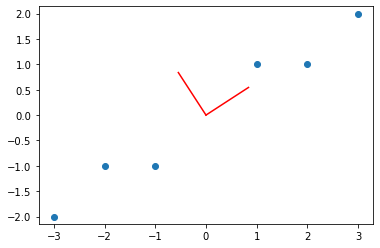

In [3]:
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

cov = pca.get_covariance()
from numpy import linalg as LA
w, v = LA.eig(cov)

plt.scatter(X[:,0],X[:,1])
plt.plot([0,v[0,0]],[0,v[1,0]],color='red')
plt.plot([0,v[0,1]],[0,v[1,1]],color='red')
plt.axis('equal')

We then went ahead and looked at a more complicated thing: Some simulated XPS spectra with background

Text(0, 0.5, 'Counts [a.U.]')

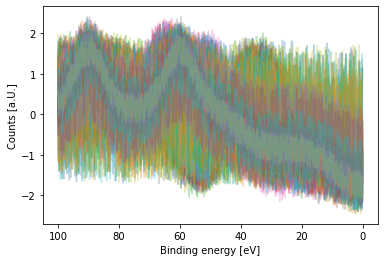

In [18]:
def gau(E,E0,I0,gamma):
    """Gaussian function

    Args:
        E (float): _description_
        E0 (float): _description_
        I0 (float): _description_
        gamma (float): _description_

    Returns:
        np.array: Gaussian function
    """
    func = I0*(1/(gamma*np.sqrt(2*np.pi)))*np.exp(-(E-E0)**2/(2*gamma**2))
    return func

def shir(x,y,k):
    """Shirley background generation

    Args:
        E (float): energy
        k (_type_): amount

    Returns:
        np.array: Shirley background
    """
    lx = len(x)
    S = [k*np.trapz(y[lx-i:],x[lx-i:]) for i in range(lx)]
    return S

E = np.linspace(0,100,1000)
gs = []
for offs,E0 in zip([10,15,30],[30,50,60]):
    for i in range(30):
        I0 = np.random.rand()*3
        y = gau(E,E0+offs,I0,5)+gau(E,E0,I0,5)
        s = shir(E,y,0.05)
        gs.append(y+s+0.1*np.random.rand(len(s)))

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
trans = scale.fit_transform(np.array(gs).T)

#note: one typically plots XPS data on an inverted x-axis
fig, ax = plt.subplots()
_ = ax.plot(E,trans,alpha=0.3)
ax.invert_xaxis()
ax.set_xlabel('Binding energy [eV]')
ax.set_ylabel('Counts [a.U.]')


ok we're almost at the thing that I actually want to show you ... let's plot the scaled data (because we said this is better) PCA values

[0.50170769 0.20423618 0.03176281 0.01240768 0.01168361]


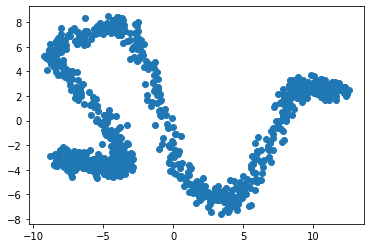

In [19]:
pca = PCA(n_components=5)
emb = pca.fit_transform(trans)
print(pca.explained_variance_ratio_)

plt.scatter(emb[:,0],emb[:,1])

ok crazy enough but what can I do with this now? We can use it to denoise! The simple trick is that we can make for instance all the components but the first few (that explain 50%, 20%, 3% etc ...) of the variance ... let's see what happens

In [46]:
from copy import copy
emb_truncated = copy(emb)
emb_truncated[:,4:] = 0

ok great so now we can even inversely transform!
How can we do this magic trick? Quite simple: Look at the top figure in this notebook, we effectively projected everything on the principal component ... now we just need to translate back to the cartesian coordinates with the use of our high dimensional covariance matrix!

Or in more mathematical correct terms:

The inverse PCA transform is done by multiplying the eigenvectors of the covariance matrix by the inverse of the PCA transformation matrix.

In [47]:
inv_truncated = pca.inverse_transform(emb_truncated)

Text(0, 0.5, 'Counts [a.U.]')

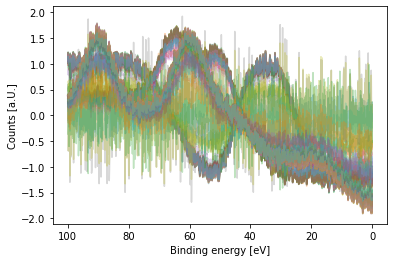

In [48]:
fig, ax = plt.subplots()
_ = ax.plot(E,inv_truncated,alpha=0.3)
ax.invert_xaxis()
ax.set_xlabel('Binding energy [eV]')
ax.set_ylabel('Counts [a.U.]')

ok this looks a little less noisy doesn't it?

let's check...

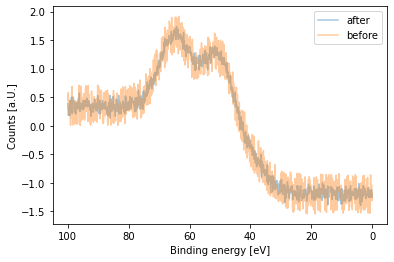

In [49]:
fig, ax = plt.subplots()
_ = ax.plot(E,inv_truncated[:,42],alpha=0.4,label='after')
_ = ax.plot(E,trans[:,42],alpha=0.4,label='before')

ax.invert_xaxis()
ax.set_xlabel('Binding energy [eV]')
ax.set_ylabel('Counts [a.U.]')
plt.legend()

# Tasks for you

1) find out what happens when you reduce the number of values that are non-zero

In [61]:
#code goes here or modify above

2. Try to do a nnmf on the noise reduced data

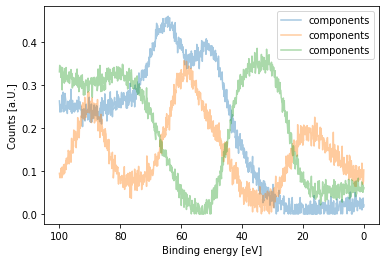

In [57]:
#standart interaction with sklearn is always:


X = scale.inverse_transform(inv_truncated)
y = 0 #don't have it in this case


from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0,
            beta_loss='kullback-leibler',max_iter=3000,solver='mu')

W = model.fit_transform(X.T)
H = model.components_

fig, ax = plt.subplots()
_ = ax.plot(E,H.T,alpha=0.4,label='components')
ax.invert_xaxis()
ax.set_xlabel('Binding energy [eV]')
ax.set_ylabel('Counts [a.U.]')
plt.legend()

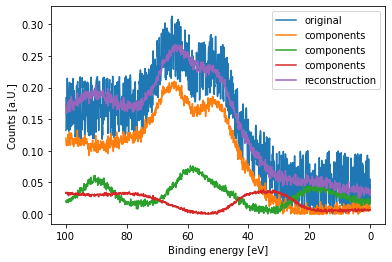

In [60]:
fig, ax = plt.subplots()
plt.plot(E,gs[43],label='original')
plt.plot(E,W[43]*H.T,label='components')
plt.plot(E,np.sum(W[43]*H.T,axis=1),label='reconstruction')
ax.invert_xaxis()
ax.set_xlabel('Binding energy [eV]')
ax.set_ylabel('Counts [a.U.]')
plt.legend()